In [0]:
!pip install --upgrade imbalanced-learn
from google.colab import drive
drive.mount('/content/drive')

     |████████████████████████████████| 174kB 39.5MB/s 
  Found existing installation: imbalanced-learn 0.4.3
    Uninstalling imbalanced-learn-0.4.3:
      Successfully uninstalled imbalanced-learn-0.4.3
Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


## Load data

In [0]:
import numpy as np
import pandas as pd
import pickle
import gensim
import nltk
import re

from tqdm import trange
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
from sklearn.ensemble import IsolationForest
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from imblearn import FunctionSampler
from imblearn.pipeline import make_pipeline
from imblearn.over_sampling import SMOTE, ADASYN, BorderlineSMOTE, KMeansSMOTE

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
np.random.seed(2018)
nltk.download('wordnet')

Using TensorFlow backend.


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [0]:
def save(obj, filename):
  with open(filename, 'wb') as f:
    pickle.dump(obj, f)
  print("Saved at {}!".format(filename))

def load_original_data():
  with open('random_songs_df.pkl', 'rb') as f:
    df_random = pickle.load(f)
  
  with open('saved_songs_df.pkl', 'rb') as f:
    df_saved = pickle.load(f)
  
  return df_random, df_saved

df_random, df_saved = load_original_data()
df_random['label'] = 0
df_saved['label'] = 1
df_all = df_random.append(df_saved, ignore_index=True)
drop_features = ['id', 'speechiness', 'genres', 'name', 'artist', 'popularity', 
                 'lyrics', 'artist_id', 'language', 'processed_lyrics', 'mode']

## Preprocess data
Remove words like `[Chorus]` and `[Verse]`. Tokenize and stem!

In [0]:
stemmer = SnowballStemmer("english")

def lemmatize_stemming(text):
  return stemmer.stem(WordNetLemmatizer().lemmatize(text, pos='v'))

def preprocess(text):
  result = []
  text = re.sub('\[.*\]', '', text)
  for token in gensim.utils.simple_preprocess(text):
    if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3:
        result.append(lemmatize_stemming(token))
  return result

In [0]:
filtered_df = df_all[(df_all['lyrics'] != "NA") & (df_all['language'] == "en")]
filtered_df['processed_lyrics'] = filtered_df['lyrics'].apply(preprocess)

x_train, x_test, y_train, y_test = train_test_split(filtered_df.drop('label', axis=1), filtered_df['label'], test_size=0.2, random_state=0)
train_df = pd.DataFrame(x_train)
train_df['label'] = y_train

test_df = pd.DataFrame(x_test)
test_df['label'] = y_test

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


## Create LDA Model

In [0]:
lda_dir = "/content/drive/My Drive/models/lda/"
def build_lda(df, num_topics, no_below=30, no_above=0.19, show_topics=False):
  lda_filename = lda_dir + "lda15_{}topics.pkl".format(num_topics)
  dict_filename = lda_dir + "{}-{}_dict.pkl".format(no_below, int(no_above*100))
  try:
    with open(dict_filename, 'rb') as f:
      dictionary = pickle.load(f)
      
    with open(lda_filename, 'rb') as f:
      lda_model = pickle.load(f)
    
  except Exception:
    all_processed_lyrics = df['processed_lyrics'].tolist()
    dictionary = gensim.corpora.Dictionary(all_processed_lyrics)
    dictionary.filter_extremes(no_below=20, no_above=0.2)
    save(dictionary, dict_filename)
    
    bow_corpus = [dictionary.doc2bow(lyric) for lyric in all_processed_lyrics]
    lda_model =  gensim.models.LdaMulticore(bow_corpus, 
                                      num_topics = num_topics, 
                                      id2word = dictionary,                                    
                                      passes = 15,
                                      workers = 3)
    save(lda_model, lda_filename)
                                    
  if show_topics:
    print("Dictionary length is", len(dictionary.keys()))
    for idx, topic in lda_model.print_topics(-1):
        print("Topic: {} | Words: {}".format(idx, topic))
  
  return lda_model, dictionary
                                   
def get_topic_dist(song, lda_model, dictionary, num_topics):
  topic_dist = [0]*num_topics
  bow_vector = dictionary.doc2bow(song)
  for index, score in sorted(lda_model[bow_vector], key=lambda tup: -1*tup[1]):
    topic_dist[index] = score
  return topic_dist

def topify_lyrics(df, num_topics, show_topics=False):
  df = df.copy()
  topic_headers = ['topic%s' % i for i in range(num_topics)]
  lda_model, dictionary = build_lda(df, num_topics=num_topics, show_topics=show_topics); print("Built LDA Model!")
  topic_columns = df['processed_lyrics'].apply(get_topic_dist, args=(lda_model, dictionary, num_topics,)); print("Processed Lyrics!")
  df[topic_headers] = pd.DataFrame(topic_columns.values.tolist(), index = df.index)
  return df 

# topify_df = topify_lyrics(train_df, 5, show_topics=True)

## Dimensionality Reduction

In [0]:
def normalize_dataframe(df, skip_features=[]):
  df = df.copy()
  features = list(set(df.columns.tolist()) - set(skip_features + ['label']))
  scaler = MinMaxScaler() 
  df[features] = scaler.fit_transform(df[features]) 
  return df

### Use PCA to reduce dimensions

In [0]:
def apply_pca(df, n_components):
  pca = PCA(n_components=n_components)
  pca_df = pd.DataFrame(
      pca.fit_transform(df.drop('label', axis=1)),
      columns=['PCA%i' % i for i in range(n_components)], 
      index=df.index)
      
  plt.plot(pca.explained_variance_ratio_)
  return pd.concat([pca_df, df['label']], axis=1)

feature_df = train_df.drop(drop_features, axis=1)

pca_df = apply_pca(normalize_dataframe(topic_df), 3)
save(pca_df, "pca.pkl")

NameError: ignored

In [0]:
%matplotlib inline

def plot_pca(pca_df):
  fig = plt.figure(figsize=(10,10))
  ax = fig.add_subplot(111, projection='3d')
  x = np.array(pca_df['PCA0'])
  y = np.array(pca_df['PCA1'])
  z = np.array(pca_df['PCA2'])
  
  ax.scatter(x,y,z, marker="s", c=pca_df["label"], s=10, cmap="RdBu", alpha=0.5)
  # ax.view_init(azim=250)
  plt.show()

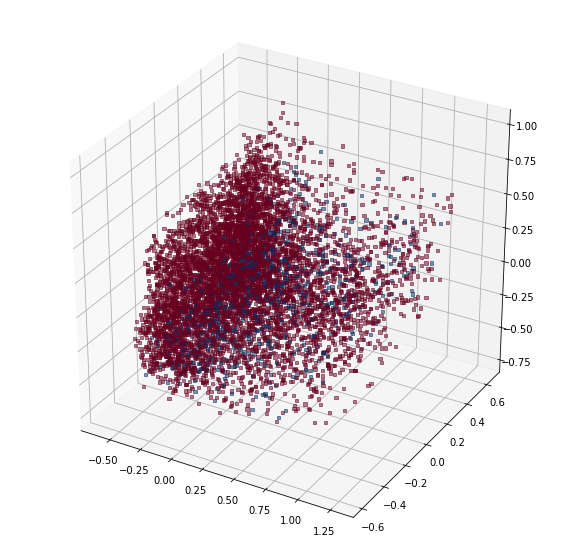

In [0]:
plot_pca(pca_df)

### Plot tSNE

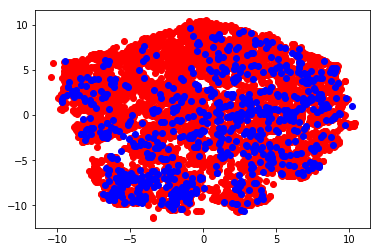

In [0]:
def plot_2dTSNE(tsne, df, pca_components=None):
  label = df['label']
  if pca_components:
    df = apply_pca(normalize_dataframe(df), pca_components)
  
  train_2d = tsne.fit_transform(df.drop('label', axis=1))
  plt.scatter(train_2d[label == 0 , 0], train_2d[label == 0, 1], c="r", label="Random")
  plt.scatter(train_2d[label == 1, 0], train_2d[label == 1, 1], c="b", label="Saved")

tsne = TSNE(n_components=2, perplexity=40, n_iter=300, verbose=2)
plot_2dTSNE(tsne, feature_df)

In [0]:
def plot_3dtsne(tsne, df, pca_components=None):
  label = df['label']
  
  if pca_components:
    df = apply_pca(normalize_dataframe(df), pca_componennts)
  
  fig = plt.figure(figsize=(10,10))
  ax = fig.add_subplot(111, projection='3d')
  
  train_3d = tsne.fit_transform(train_df.drop(drop_features, axis=1))
  ax.scatter(train_3d[label == 0, 0], train_3d[label == 0, 1], train_3d[label == 0, 2], c="r", s=10, alpha=0.5)
  ax.scatter(train_3d[label == 1, 0], train_3d[label == 1, 1], train_3d[label == 1, 2], c="b", s=10, alpha=0.5)
  # ax.view_init(azim=250)
  plt.show()

tsne_3 = TSNE(n_components=3, random_state=0, perplexity=25, n_iter=550, verbose=2)
plot_3dtsne(tsne_3, feature_df)

## Remove outliers before resampling

In [0]:
def outlier_rejection(X, y):
    """This will be our function used to resample our dataset."""
    model = IsolationForest(max_samples=100,
                            contamination='auto',
                            random_state=rng,
                            behaviour='new')
    model.fit(X)
    y_pred = model.predict(X)
    return X[y_pred == 1], y[y_pred == 1]


rng = np.random.RandomState(42)
reject_sampler = FunctionSampler(func=outlier_rejection)

# saved_processed_df = filtered_df[filtered_df['label'] == 1]
# topic_df_with_labels = saved_processed_df[['topic%s' % i for i in range(NUM_TOPICS)] + ['label']]

X_inliers, y_inliers = reject_sampler.fit_resample(train_df.drop(drop_features + ['label'], axis=1), train_df['label'])
train_inliers = pd.DataFrame(X_inliers)
train_inliers['label'] = y_inliers

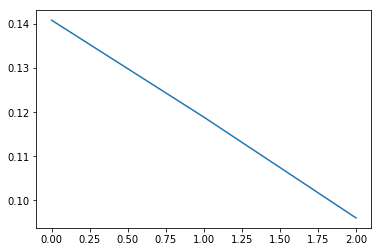

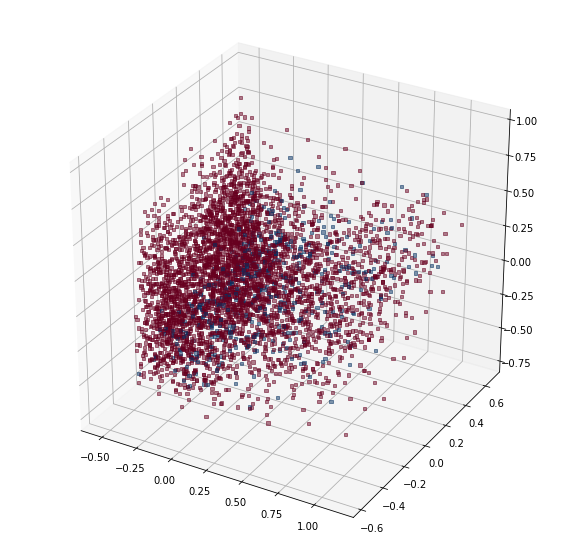

Saved at inliers_pca.pkl!


In [0]:
inliers_pca = apply_pca(topics_inliers, 3)
plot_pca(inliers_pca)
save(inliers_pca, "inliers_pca.pkl")

## Oversample liked songs

In [0]:
def resample_df(df):
  df = df.copy()
  clustering = True
  t = 0.5
  while clustering:
    try:
      X_resampled, y_resampled = KMeansSMOTE(cluster_balance_threshold=t).fit_resample(df.drop('label', axis=1), df['label'])
      clustering = False
    except Exception:
      t -= 0.01
    if t < 0: return None
       
  resampled_df = pd.DataFrame(X_resampled)
  resampled_df['label'] = y_resampled
  print(resampled_df.shape, "threshold:{}".format(t))
  return resampled_df


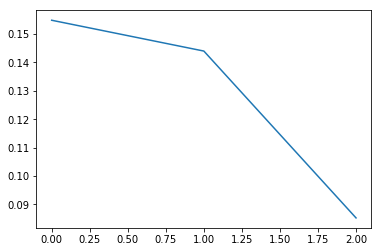

In [0]:
resample_pca_df = apply_pca(normalize_dataframe(resampled_df), 3)

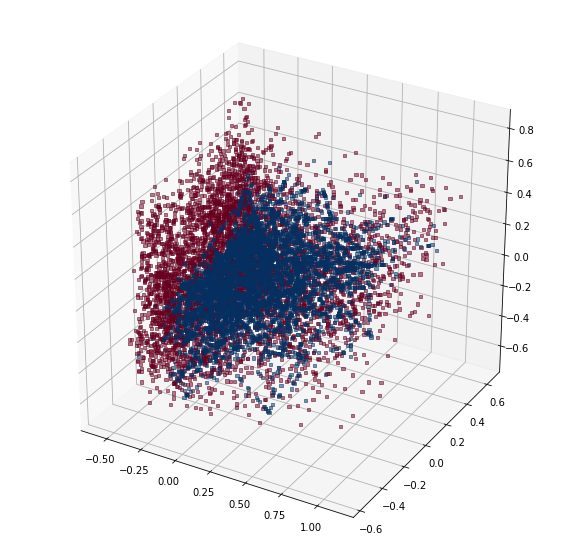

In [0]:
plot_pca(resample_pca_df)

In [0]:
tsne = TSNE(n_components=2, perplexity=90, n_iter=1000, verbose=2)
plot_2dTSNE(tsne, resampled_df)

In [0]:
tsne = TSNE(n_components=2, perplexity=50, n_iter=700, verbose=2)
plot_2dTSNE(tsne, resampled_df, pca_components=6)

## Train ANN Model

In [0]:
import os, datetime
import tensorflow as tf
    
def sensitivity(y_true, y_pred):
  neg_y_true = 1 - y_true
  neg_y_pred = 1 - y_pred
  fn = tf.keras.backend.sum(y_true * neg_y_pred)
  tp = tf.keras.backend.sum(y_true * y_pred)
  return fn / (tp + fn + tf.keras.backend.epsilon())
  
def get_compiled_model(input_dim):
  model = tf.keras.Sequential([
    tf.keras.layers.Dense(input_dim, activation='relu', input_dim=input_dim),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(int(input_dim), activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(int(input_dim/2), activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(1, activation='sigmoid'),
    tf.keras.layers.Flatten()
  ])

  model.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=['accuracy', sensitivity])
  return model

def df_to_dataset(df, shuffle=True, batch_size=32):
  df = df.copy()
  labels = df.pop('label')
  ds = tf.data.Dataset.from_tensor_slices((df.values, labels.values))
  if shuffle: ds = ds.shuffle(buffer_size=len(df))
  ds = ds.batch(batch_size)
  return ds

In [0]:
def train(df, epochs=1, num_folds=5):
  num_folds  = 5
  df = df.copy()
  kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)
  X = df.drop('label', axis=1)
  Y = df['label']
  cvscores_sensitivity = []
  cvscores_accuracy = []
  input_dim = X.shape[1]
  for index, (train, test) in enumerate(kfold.split(X, Y)):
    filepath="/content/drive/My Drive/models/layer%s_cv%s.hdf5" % (len(df.columns.tolist()), index)
    # checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath, monitor='sensitivity', verbose=0)
    model = get_compiled_model(input_dim)
    model.fit(X.loc[train], Y.loc[train], epochs=epochs, 
              batch_size=32, verbose=0, callbacks = [])
    model.save_weights(filepath)
    # model.load_weights(filepath)
    scores = model.evaluate(X.loc[test], Y.loc[test], verbose=0)
    print("Fold {} ->".format(index), "%s: %.2f%% | %s: %.2f%%" % 
          (model.metrics_names[1], scores[1]*100, 
            model.metrics_names[2], scores[2]*100))
    cvscores_accuracy.append(scores[1] * 100)
    cvscores_sensitivity.append(scores[2] * 100)
    
  print("sensitivity: %.2f%% (+/- %.2f%%)" % (np.mean(cvscores_sensitivity), np.std(cvscores_sensitivity)))
  print("accuracy: %.2f%% (+/- %.2f%%)" % (np.mean(cvscores_accuracy), np.std(cvscores_accuracy)))
  print("\n")
  
  return cvscores_sensitivity, cvscores_accuracy

In [0]:
def pipeline(df, num_topics):
  topified = topify_lyrics(train_df, num_topics)
  topified.drop(drop_features, axis=1, inplace=True) 
  resampled = resample_df(topified)
  if type(resampled) != None:
    normalized = normalize_dataframe(resampled)
    return normalized
  else:
    return None
  
all_cv_sensitivity_scores = []
all_cv_accuracy_scores = []

for i in range(6, 10):
  print("-"*15)
  print("{} TOPICS".format(i))
  p_df = pipeline(train_df, i)
  if type(p_df) != None:
    s, a = train(p_df, 5) 
    all_cv_sensitivity_scores.append(s)
    all_cv_accuracy_scores.append(a)
  else:
    print("Skipping {} topics...".format(i))

---------------
6 TOPICS
Saved at /content/drive/My Drive/models/lda/20-20_dict.pkl!
Saved at /content/drive/My Drive/models/lda/lda15_6topics.pkl!
Built LDA Model!
Processed Lyrics!
(12590, 17) threshold:0.17999999999999972
Fold 0 -> acc: 84.27% | sensitivity: 36.93%
Fold 1 -> acc: 77.44% | sensitivity: 38.54%
Fold 2 -> acc: 81.18% | sensitivity: 34.72%
Fold 3 -> acc: 82.61% | sensitivity: 37.40%
Fold 4 -> acc: 81.65% | sensitivity: 35.32%
sensitivity: 36.58% (+/- 1.39%)
accuracy: 81.43% (+/- 2.26%)


---------------
7 TOPICS
Saved at /content/drive/My Drive/models/lda/20-20_dict.pkl!
Saved at /content/drive/My Drive/models/lda/lda15_7topics.pkl!
Built LDA Model!
Processed Lyrics!
(12590, 18) threshold:0.19999999999999973
Fold 0 -> acc: 82.68% | sensitivity: 38.23%
Fold 1 -> acc: 83.44% | sensitivity: 30.95%
Fold 2 -> acc: 81.77% | sensitivity: 37.51%
Fold 3 -> acc: 81.81% | sensitivity: 33.92%
Fold 4 -> acc: 81.53% | sensitivity: 34.67%
sensitivity: 35.06% (+/- 2.62%)
accuracy: 82.25

## Evaluate Model

In [0]:
test_df_processed = test_df.copy()
num_topics = 10
TOPIC_HEADERS = ['topic%s' % i for i in range(num_topics)]

lda_model, dictionary = build_lda(None, num_topics)
topic_columns = test_df_processed['processed_lyrics'].apply(get_topic_dist, args=(lda_model, dictionary, num_topics,))
test_df_processed[TOPIC_HEADERS] = pd.DataFrame(topic_columns.values.tolist(), index = test_df_processed.index)
normalized_test_df = normalize_dataframe(test_df_processed.drop(drop_features, axis=1))
test_ds_large = df_to_dataset(normalized_test_df, batch_size=1)

In [0]:
input_dim = normalized_test_df.shape[1]-1
test_weights="/content/drive/My Drive/models/layer{}_cv1.hdf5".format(input_dim+1)
model = get_compiled_model(input_dim)
model.load_weights(test_weights)
loss, accuracy, sensitivity = model.evaluate(test_ds_large)

W0906 14:00:47.397977 140002407409536 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


1771/1771 [==============================] - 4s 2ms/step - loss: 0.4027 - acc: 0.7933 - sensitivity: 0.0515


In [0]:
predicted_df = normalize_dataframe(test_df_processed.copy(), skip_features=drop_features)
predictions = [x[0] for x in model.predict_proba(predicted_df.drop(drop_features + ['label'], axis=1))]
predicted_df['score'] = pd.Series(predictions, index=predicted_df.index)
print(predicted_df[predicted_df['label'] == 1][['id', 'score']])

                           id     score
15787  1mQI744KrltnCU798zIGEe  0.412760
15394  574SDj6oswpGu5s9EM5mFT  0.430682
15595  2cMTIlktg3M9mXYqCPqw1J  0.194499
16128  1sCxVKWImDZSZKvG0U9B23  0.710277
15769  7pqgMEKsDMOHUdFQ7n0N9K  0.266727
15938  3KQwLKRDpTCQQeGJeb7H8A  0.475657
16144  3GnLo84IkdSWCPYt6tnLll  0.770757
15635  52iLDrSoRtf9lcgFuLVfqE  0.550464
15113  6bmE6Fe6tJRCwb0wgRsnba  0.732578
15703  2p2aCtErYX6UaFxyfpVvWC  0.371026
15499  0pB47KsDytsGM7G7EorFZE  0.375172
16014  3YU6vJbjYUG0tiJyXf9x5V  0.360148
15992  48otelBlQznqDX6Uuio485  0.661287
15840  590bUp2TKTfTS9NfiD4Nmn  0.729482
15864  4S1GTwPVpkSy7CsJIDKPEz  0.172514
15833  0w1ZtnzQmtmuuoKxHT0pLL  0.556568
15300  1qDrWA6lyx8cLECdZE7TV7  0.634182
15297  2WazybrAdTHvtwcfCAIlVj  0.279098
15796  4sy3B9TPNMIze8oFrDJnUN  0.678991
15118  09TrBtzcQQDybTzWXkQfmc  0.704185
15095  06HF5MffJ05298m4NPrVEU  0.689727
16046  2yFh7Oz9g0bpHp3iis2Iu2  0.714200
15071  64TUmDi8kUUCF816GhdRXX  0.729364
15311  6IRdLKIyS4p7XNiP8r6rsx  0.067931


In [0]:
import sklearn.metrics as metrics
x_test = normalized_test_df.drop('label', axis=1)
y_test = normalized_test_df['label']

predictions = [x[0] for x in model.predict_classes(x_test)]
def threshold_test(x_test, y_test, model):
  predictions = [x[0] for x in model.predict_proba(x_test)]
  for x in range(10):
    threshold = 0.5 - 0.05*x
    print(threshold)
    threshold_classes = [1 if x > threshold else 0 for x in predictions]
    print(pd.crosstab(pd.Series(y_test.values), pd.Series(threshold_classes), rownames=['True'], colnames=['Predicted'], margins=True))
    print(metrics.classification_report(y_test.values, threshold_classes))
    print("-"*20)
    print("\n")

threshold_test(x_test, y_test, model)

0.5
Predicted     0    1   All
True                      
0          1276  299  1575
1            67  129   196
All        1343  428  1771
              precision    recall  f1-score   support

           0       0.95      0.81      0.87      1575
           1       0.30      0.66      0.41       196

    accuracy                           0.79      1771
   macro avg       0.63      0.73      0.64      1771
weighted avg       0.88      0.79      0.82      1771

--------------------


0.45
Predicted     0    1   All
True                      
0          1217  358  1575
1            58  138   196
All        1275  496  1771
              precision    recall  f1-score   support

           0       0.95      0.77      0.85      1575
           1       0.28      0.70      0.40       196

    accuracy                           0.77      1771
   macro avg       0.62      0.74      0.63      1771
weighted avg       0.88      0.77      0.80      1771

--------------------


0.4
Predicted     0  

In [0]:
pd.crosstab(pd.Series(y_test.values), pd.Series(predictions), rownames=['True'], colnames=['Predicted'], margins=True)

Predicted,0,1,All
True,,,
0,1276,299,1575
1,67,129,196
All,1343,428,1771


In [0]:
print(metrics.classification_report(y_test.values, predictions))

              precision    recall  f1-score   support

           0       0.95      0.81      0.87      1575
           1       0.30      0.66      0.41       196

    accuracy                           0.79      1771
   macro avg       0.63      0.73      0.64      1771
weighted avg       0.88      0.79      0.82      1771

